# Big Mart Sales Prediction

Following https://www.analyticsvidhya.com/blog/2020/01/build-your-first-machine-learning-pipeline-using-scikit-learn/

## Introduction

### Problem Statement

*The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim is to build a predictive model and predict the sales of each product at a particular outlet.
Using this model, BigMart will try to understand the properties of products and outlets which play a key role in increasing sales.*

### Data Dictionary

* `Item_Identifier` -	Unique product ID
* `Item_Weight`	- Weight of product
* `Item_Fat_Content` - Whether the product is low fat or not
* `Item_Visibility` - The % of total display area of all products in a store allocated to the particular product
* `Item_Type` - The category to which the product belongs
* `Item_MRP` - Maximum Retail Price (list price) of the product
* `Outlet_Identifier` - Unique store ID
* `Outlet_Establishment_Year` - The year in which store was established
* `Outlet_Size` - The size of the store in terms of ground area covered
* `Outlet_Location_Type` - The type of city in which the store is located
* `Outlet_Type` - Whether the outlet is just a grocery store or some sort of supermarket
* `Item_Outlet_Sales` - Sales of the product in the particular store. This is the outcome variable to be predicted.

## Machine Learning Prototype

### Pre-processing

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import  RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator

In [5]:
# read the train data
train_data = pd.read_csv('datasets/bigmart/train_set.csv')

train_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [6]:
# check for the null values
train_data.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [7]:
# impute missing values in item weight by mean
train_data.Item_Weight.fillna(train_data.Item_Weight.mean(),inplace=True)
# impute outlet size in training data by mode
train_data.Outlet_Size.fillna(train_data.Outlet_Size.mode()[0],inplace=True)

In [15]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
Item_Identifier              8523 non-null object
Item_Weight                  8523 non-null float64
Item_Fat_Content             8523 non-null object
Item_Visibility              8523 non-null float64
Item_Type                    8523 non-null object
Item_MRP                     8523 non-null float64
Outlet_Identifier            8523 non-null object
Outlet_Establishment_Year    8523 non-null int64
Outlet_Size                  8523 non-null object
Outlet_Location_Type         8523 non-null object
Outlet_Type                  8523 non-null object
Item_Outlet_Sales            8523 non-null float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


One Hot Encode categorical columns (except item_Identifier) using `categorical_encoders` package.

In [31]:
# create an object of the OneHotEncoder
OHE = ce.OneHotEncoder(cols=['Item_Fat_Content',
                             'Item_Type',
                             'Outlet_Identifier',
                             'Outlet_Size',
                             'Outlet_Location_Type',
                             'Outlet_Type'],use_cat_names=True)
# encode the categorical variables
train_data = OHE.fit_transform(train_data)

Scale `Item_MVP` attribute using `StandardScaler`.

In [33]:
# create an object of the StandardScaler
scaler = StandardScaler()
# fit with the Item_MRP
scaler.fit(np.array(train_data.Item_MRP).reshape(-1,1))
# transform the data
train_data.Item_MRP = scaler.transform(np.array(train_data.Item_MRP).reshape(-1,1))

### Model Building

In [35]:
# separate the independent and target variable 
train_X = train_data.drop(columns=['Item_Identifier','Item_Outlet_Sales'])
train_Y = train_data['Item_Outlet_Sales']

# randomly split the data
train_x, test_x, train_y, test_y = train_test_split(train_X, train_Y,test_size=0.25,random_state=0)

# shape of train and test splits
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((6392, 45), (2131, 45), (6392,), (2131,))

In [36]:
# create an object of the LinearRegression Model
model_LR = LinearRegression()

# fit the model with the training data
model_LR.fit(train_x, train_y)

# predict the target on train and test data 
predict_train = model_LR.predict(train_x)
predict_test  = model_LR.predict(test_x)

# Root Mean Squared Error on train and test date
print('RMSE on train data: ', mean_squared_error(train_y, predict_train)**(0.5))
print('RMSE on test data: ',  mean_squared_error(test_y, predict_test)**(0.5))

RMSE on train data:  1120.4177139551168
RMSE on test data:  1148.721468613664


Very high RMSE on both training and validation. Let us try a tree-based model.

In [37]:
model_RFR = RandomForestRegressor(max_depth=10)

# fit the model with the training data
model_RFR.fit(train_x, train_y)

# predict the target on train and test data
predict_train = model_RFR.predict(train_x)
predict_test = model_RFR.predict(test_x)

# Root Mean Squared Error on train and test data
print('RMSE on train data: ', mean_squared_error(train_y, predict_train)**(0.5))
print('RMSE on test data: ',  mean_squared_error(test_y, predict_test)**(0.5))

RMSE on train data:  895.869677235035
RMSE on test data:  1114.4254423804691


See most important features

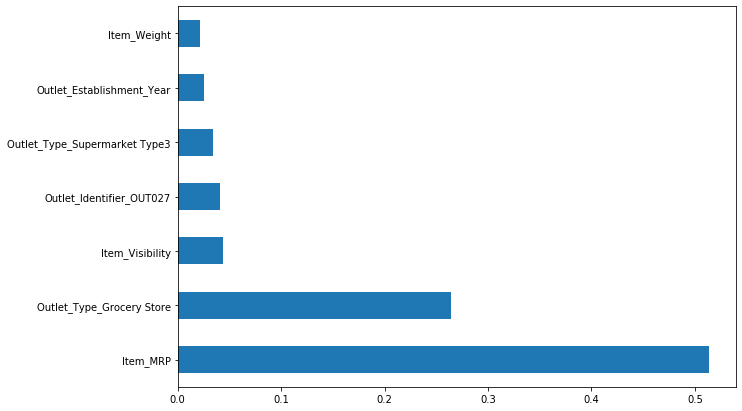

In [38]:
plt.figure(figsize=(10,7))
feat_importances = pd.Series(model_RFR.feature_importances_, index = train_x.columns)
feat_importances.nlargest(7).plot(kind='barh');

Try model using only these 7 features.

In [39]:
# training data with 7 most important features
train_x_if = train_x[['Item_MRP', 
                    'Outlet_Type_Grocery Store',
                    'Item_Visibility',
                    'Outlet_Type_Supermarket Type3',
                    'Outlet_Identifier_OUT027',
                    'Outlet_Establishment_Year',
                    'Item_Weight']]
# test data with 7 most important features
test_x_if = test_x[['Item_MRP', 
                    'Outlet_Type_Grocery Store',
                    'Item_Visibility',
                    'Outlet_Type_Supermarket Type3',
                    'Outlet_Identifier_OUT027',
                    'Outlet_Establishment_Year',
                    'Item_Weight']]

# create an object of the RandfomForestRegressor Model
model_RFR_with_if = RandomForestRegressor(max_depth=10,random_state=2)

# fit the model with the training data
model_RFR_with_if.fit(train_x_if, train_y)

# predict the target on the training and test data
predict_train_with_if = model_RFR_with_if.predict(train_x_if)
predict_test_with_if = model_RFR_with_if.predict(test_x_if)

# Root Mean Squared Error on the train and test data
print('RMSE on train data: ', mean_squared_error(train_y, predict_train_with_if)**(0.5))
print('RMSE on test data: ',  mean_squared_error(test_y, predict_test_with_if)**(0.5))

RMSE on train data:  899.9500257797899
RMSE on test data:  1117.3398212310208


Decide to use these features and this model.

## Build Pipeline

We will define our pipeline in three stages:

1. Create the required binary features
2. Perform required data preprocessing and transformations
3. Build a model to predict the sales

### Create transformer

We need to create 3 new binary columns using a custom transformer.

In [45]:
# define the class OutletTypeEncoder
# This will be our custom transformer that will create 3 new binary columns
# custom transformer must have methods fit and transform
class OutletTypeEncoder(BaseEstimator):

    def __init__(self):
        pass

    def fit(self, documents, y=None):
        return self

    def transform(self, x_dataset):
        x_dataset['outlet_grocery_store'] = (x_dataset['Outlet_Type'] == 'Grocery Store')*1
        x_dataset['outlet_supermarket_3'] = (x_dataset['Outlet_Type'] == 'Supermarket Type3')*1
        x_dataset['outlet_identifier_OUT027'] = (x_dataset['Outlet_Identifier'] == 'OUT027')*1
        
        return x_dataset

### ColumnTransformer

Next we will define the pre-processing steps required before the model building process.

* Drop the columns – Item_Identifier, Outlet_Identifier, Item_Fat_Content, Item_Type, Outlet_Identifier, Outlet_Size, Outlet_Location_Type and Outlet_Establishment_Year
* Impute missing values in column Item_Weight with mean
* Scale the column Item_MRP using StandardScaler().

In [46]:
pre_process = ColumnTransformer(remainder='passthrough',
                                transformers=[('drop_columns', 'drop', ['Item_Identifier',
                                                                        'Outlet_Identifier',
                                                                        'Item_Fat_Content',
                                                                        'Item_Type',
                                                                        'Outlet_Identifier',
                                                                        'Outlet_Size',
                                                                        'Outlet_Location_Type',
                                                                        'Outlet_Type'
                                                                       ]),
                                              ('impute_item_weight', SimpleImputer(strategy='mean'), ['Item_Weight']),
                                              ('scale_data', StandardScaler(),['Item_MRP'])])

### Pipeline and predictions

In [48]:
# Define the Pipeline
"""
Step1: get the oultet binary columns
Step2: pre processing
Step3: Train a Random Forest Model
"""
model_pipeline = Pipeline(steps=[('get_outlet_binary_columns', OutletTypeEncoder()), 
                                 ('pre_processing',pre_process),
                                 ('random_forest', RandomForestRegressor(max_depth=10,random_state=2))
                                 ])

Apply it to fresh training set.

In [51]:
# read the training data set
data = pd.read_csv('datasets/bigmart/train_set.csv')

# seperate the independent and target variables
X_train = data.drop(columns=['Item_Outlet_Sales'])
y_train = data['Item_Outlet_Sales']

# fit the pipeline with the training data
model_pipeline.fit(X_train, y_train)

# predict target values on the training data
model_pipeline.predict(X_train)

array([4348.01437159,  693.40276088, 2323.35268531, ..., 1300.83665376,
       1508.86795688, 1152.35475793])

Apply to test set.

In [53]:
# read the test data set
X_test = pd.read_csv('datasets/bigmart/test_set.csv')


# predict target values on the test data
model_pipeline.predict(X_test)

array([1646.0548363 , 1305.4298012 ,  658.42325097, ..., 1848.60226305,
       3959.67937864, 1384.01466986])